<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Reza Vahidimajd
### Student Number : 99102491
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


ModuleNotFoundError: No module named 'torchvision'

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [13]:
# run this cell to download and prepare data

from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


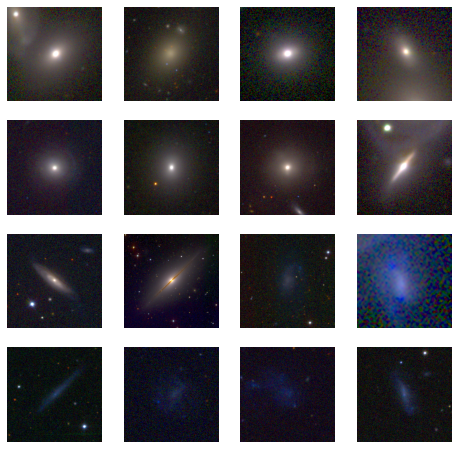

In [14]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
from matplotlib import image

figure = plt.figure(figsize=(8, 8))
clss = 0
count = 0
for i in range(4):
    for j in range(len(df)):
      if df["class_label"][j] == i:
        my_image = image.imread('./efigi-1.6/png/' + df["name"][j] + '.png')
        figure.add_subplot(4, 4, count+1)
        plt.axis("off")
        plt.imshow(my_image, cmap="gray")
        count += 1
        if count % 4 == 0:
          break
plt.show()


# Define Dataset (20 Points)

In [15]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
np.random.seed(11)

class GalaxyDataSet(Dataset):
    def __init__(self, names, class_labels, transform):
        self.names = names
        self.class_labels = class_labels
        self.transform = transform
        pass

    def __len__(self):
        return len(self.names)
        pass

    def __getitem__(self, index):
        img = read_image("./efigi-1.6/png/" + self.names[index] + ".png")
        label = self.class_labels[index]
        img = self.transform(img)
        return img, label
        pass



train, test = train_test_split(df, shuffle = True, test_size= 0.3)

train_ds = GalaxyDataSet(list(train["name"]), list(train["class_label"]), transforms.Compose([transforms.ToPILImage(),
                                                                                                           transforms.Resize(32),
                                                                                                           transforms.ToTensor()]))
test_ds = GalaxyDataSet(list(test["name"]), list(test["class_label"]), transforms.Compose([transforms.ToPILImage(),
                                                                                                           transforms.Resize(32),
                                                                                                           transforms.ToTensor()]))

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True)



# Define Model (20 Points)

In [16]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.classification = nn.Sequential(
          nn.Linear(3072, 1024),
          nn.ReLU(),
          nn.BatchNorm1d(1024),
          nn.Linear(1024, 128),
          nn.ReLU(),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128, 4),
          nn.ReLU(),
          nn.ReLU()
        )
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classification(x)
        return x

# Train Model (30 Points)

In [17]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
from torch import optim


losses, accuracies = [], []
model = ClassifierModel().to(device)
lf = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(20):
  total_loss = 0
  correct = 0
  for X, Y in train_dl:
    print(X[0])
    prd = model(X)
    opt.zero_grad()
    loss = lf(prd, Y)
    loss.backward()
    opt.step()
    total_loss += loss.item()
    preds = prd.argmax(dim=1)
    correct += (preds == Y).sum().item()
  acc = correct / len(train)
  total_loss /= len(train_dl)
  losses.append(total_loss)
  accuracies.append(acc)
  print("epoch: " + str(epoch) + ", accuracy: " + str(acc) + ", loss: " + str(total_loss))


epoch: 0, accuracy: 0.5846153846153846, loss: 1.0605229154611244
epoch: 1, accuracy: 0.7224358974358974, loss: 0.7965281296999026
epoch: 2, accuracy: 0.7769230769230769, loss: 0.6730954807538253
epoch: 3, accuracy: 0.7977564102564103, loss: 0.5981732085729257
epoch: 4, accuracy: 0.8176282051282051, loss: 0.5318085879851611
epoch: 5, accuracy: 0.830448717948718, loss: 0.49140956294842253
epoch: 6, accuracy: 0.8371794871794872, loss: 0.45588445831567814
epoch: 7, accuracy: 0.8416666666666667, loss: 0.4337524426289094
epoch: 8, accuracy: 0.8506410256410256, loss: 0.4168838227406526
epoch: 9, accuracy: 0.8612179487179488, loss: 0.39410301729654656
epoch: 10, accuracy: 0.857051282051282, loss: 0.38378471586948787
epoch: 11, accuracy: 0.8692307692307693, loss: 0.36971244850219825
epoch: 12, accuracy: 0.882051282051282, loss: 0.34301504485118084
epoch: 13, accuracy: 0.8788461538461538, loss: 0.34664985552812233
epoch: 14, accuracy: 0.8807692307692307, loss: 0.3375023780724941
epoch: 15, accur

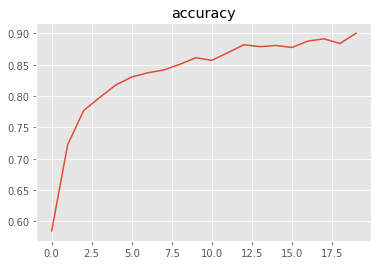

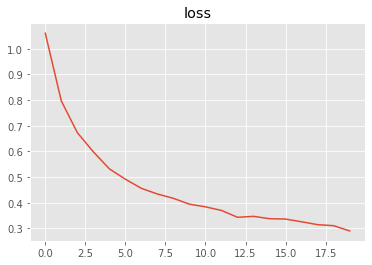

In [19]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(accuracies)
plt.title("accuracy")
plt.show()
plt.plot(losses)
plt.title("loss")
plt.show()


# Test Model (20)

accuracy: 0.8101644245142003, loss: 0.48295202673900695


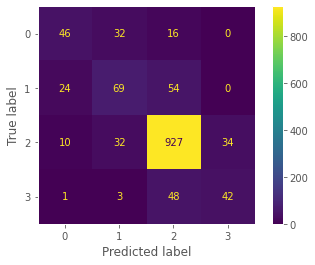

In [30]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
from sklearn import metrics

pred, true = [], []
loss_total = 0
correct_test = 0
with torch.no_grad():
  for X, Y in test_dl:
    test_preds = model(X)
    loss = lf(test_preds, Y)
    loss_total += loss.item()
    preds = test_preds.argmax(dim=1)
    correct_test += (preds == Y).sum().item()
    for i in range(len(Y)):
      true.append(Y[i])
      pred.append(preds[i])
  acc = correct_test / len(test)
  loss_total /= len(test_dl)
  print("accuracy: " + str(acc) + ", loss: " + str(loss_total))
conf_matrix = metrics.confusion_matrix(true, pred)

metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.grid(False)
plt.show()